<a href="https://colab.research.google.com/github/FinAminToastCrunch/Probabalistic_Graph_Residual/blob/main/notebook_version_row_wise_kl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-geometric
!pip install deeprobust

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 6.5 MB/s 
     |████████████████████████████████| 209 kB 47.9 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 147 kB 65.2 MB/s 
     |████████████████████████████████| 112 kB 60.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=72d90ec22a4f4cf15b98267c8a836eed61197c0cb75bb52876a5607a992b4123
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 

In [2]:
class Args:
  dataset = 'Cora'
  seed = 15
  model = 'AirGNN'
  alpha = 0.1
  lambda_amp = 0.1
  lcc = False
  normalize_features = True
  random_splits = False
  runs = 10
  epochs = 10
  lr = 0.01
  weight_decay = 0.0005
  early_stopping = 100
  hidden = 64
  dropout = 0.8
  K = 10
  model_cache = False

In [3]:
#adv_attack.py

from deeprobust.graph.data import Dataset
from deeprobust.graph.defense import GCN
from deeprobust.graph.targeted_attack import Nettack
import pickle
import argparse
import torch
import numpy as np
from tqdm import tqdm
#from datasets import uniqueId, str2bool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

def cache_nettack_feature_attack_data(args):
    n_perturbations_candidates = [0, 1, 2, 5, 10, 20, 50, 80]
    print("====preparing dataset: %s=====" % (args.dataset))
    cache_dataset(args.dataset, n_perturbations_candidates, args)


def cache_dataset(dataset_name, n_perturbations_candidates, args):
    data = Dataset(root='/tmp/', name=(dataset_name).lower(), seed=args.seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test
    surrogate = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1,
                    nhid=16, dropout=0, with_relu=False, with_bias=False, device=device)
    surrogate = surrogate.to(device)
    surrogate.fit(features, adj, labels, idx_train)

    node_list = select_nodes(data)
    print(data, node_list, args)

    for target_node in tqdm(node_list):
        for perturbation in n_perturbations_candidates:

            uid = uniqueId(dataset_name, target_node, perturbation)
            n_perturbations = int(perturbation)
            if n_perturbations != 0:
                model = Nettack(surrogate, nnodes=adj.shape[0], attack_structure=False,
                                attack_features=True, device=device)
                model = model.to(device)
                model.attack(features, adj, labels, target_node, n_perturbations, verbose=False)
                modified_features = model.modified_features
                data.features = modified_features

            pickle.dump(data, open("./fixed_data/adv_attack/" + uid + ".pickle", 'wb'))
            print(uid, "has been save")

def classification_margin(output, true_label):
    """Calculate classification margin for outputs.
    `probs_true_label - probs_best_second_class`
    Parameters
    ----------
    output: torch.Tensor
        output vector (1 dimension)
    true_label: int
        true label for this node
    Returns
    -------
    list
        classification margin for this node
    """
    probs = torch.exp(output)
    probs_true_label = probs[true_label].clone()
    probs[true_label] = 0
    probs_best_second_class = probs[probs.argmax()]
    return (probs_true_label - probs_best_second_class).item()


def select_nodes(data, target_gcn=None):
    '''
    selecting nodes as reported in nettack paper:
    (i) the 10 nodes with highest margin of classification, i.e. they are clearly correctly classified,
    (ii) the 10 nodes with lowest margin (but still correctly classified) and
    (iii) 20 more nodes randomly
    '''
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    if target_gcn is None:
        target_gcn = GCN(nfeat=features.shape[1],
                         nhid=16,
                         nclass=labels.max().item() + 1,
                         dropout=0.5, device=device)
        target_gcn = target_gcn.to(device)
        target_gcn.fit(features, adj, labels, idx_train, idx_val, patience=30)
    target_gcn.eval()
    output = target_gcn.predict()

    margin_dict = {}
    for idx in idx_test:
        margin = classification_margin(output[idx], labels[idx])
        if margin < 0:  # only keep the nodes correctly classified
            continue
        margin_dict[idx] = margin
    sorted_margins = sorted(margin_dict.items(), key=lambda x: x[1], reverse=True)
    high = [x for x, y in sorted_margins[: 10]]
    low = [x for x, y in sorted_margins[-10:]]
    other = [x for x, y in sorted_margins[10: -10]]
    other = np.random.choice(other, 20, replace=False).tolist()

    return high + low + other


# def main():
#     # parser = argparse.ArgumentParser()
#     # parser.add_argument('--dataset', type=str, required=True)
#     # parser.add_argument('--seed', type=int, default=15)
#     # args = parser.parse_args()
#     args = Args()
#     print('arg : ', args)
#     cache_nettack_feature_attack_data(args)


# if __name__ == "__main__":
#     main()
    


device: cuda


In [4]:
# dataset.py

import os.path as osp
import torch

from torch_geometric.datasets import Planetoid, Coauthor, Amazon
import torch_geometric.transforms as T
from deeprobust.graph.data import Dataset, Dpr2Pyg

import argparse

def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Unsupported value encountered.')

def uniqueId(dataset_name, target_node, perturbation):
    return dataset_name.lower() +"_"+str(target_node)+"_"+str(perturbation)


def prepare_data(args, lcc=False):
    transform = T.ToSparseTensor()
    if args.dataset == "Cora" or args.dataset == "CiteSeer" or args.dataset == "PubMed":
        if lcc:
            dpr_data = Dataset(root='/tmp/', name=(args.dataset).lower())
            dataset = Dpr2Pyg(dpr_data, transform=transform)
        else:
            dataset = get_planetoid_dataset(args.dataset, args.normalize_features, transform)
        permute_masks = random_planetoid_splits if args.random_splits else None

    elif args.dataset == "cs" or args.dataset == "physics":
        dataset = get_coauthor_dataset(args.dataset, args.normalize_features, transform)
        permute_masks = random_coauthor_amazon_splits

    elif args.dataset == "computers" or args.dataset == "photo":
        dataset = get_amazon_dataset(args.dataset, args.normalize_features, transform)
        permute_masks = random_coauthor_amazon_splits
    print("Data:", dataset[0])

    return dataset, permute_masks


def get_planetoid_dataset(name, normalize_features=False, transform=None):
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    #print(f"path = {path}")
    path = '/content/../data/Cora'
    dataset = Planetoid(path, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset


def get_coauthor_dataset(name, normalize_features=False, transform=None):
    path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    dataset = Coauthor(path, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset


def get_amazon_dataset(name, normalize_features=False, transform=None):
    path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    dataset = Amazon(path, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, num_classes, lcc_mask=None):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing

    indices = []
    if lcc_mask is not None:
        for i in range(num_classes):
            index = (data.y[lcc_mask] == i).nonzero().view(-1)
            index = index[torch.randperm(index.size(0))]
            indices.append(index)
    else:
        for i in range(num_classes):
            index = (data.y == i).nonzero().view(-1)
            index = index[torch.randperm(index.size(0))]
            indices.append(index)

    train_index = torch.cat([i[:20] for i in indices], dim=0)

    rest_index = torch.cat([i[20:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(rest_index[:500], size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index[500:1500], size=data.num_nodes)

    return data


def random_coauthor_amazon_splits(data, num_classes, lcc_mask=None, seed=None):
    # Set random coauthor/co-purchase splits:
    # * 20 * num_classes labels for training
    # * 30 * num_classes labels for validation
    # rest labels for testing
    g = None
    if seed is not None:
        g = torch.Generator()
        g.manual_seed(seed)

    indices = []
    if lcc_mask is not None:
        for i in range(num_classes):
            index = (data.y[lcc_mask] == i).nonzero().view(-1)
            index = index[torch.randperm(index.size(0), generator=g)]
            indices.append(index)
    else:
        for i in range(num_classes):
            index = (data.y == i).nonzero().view(-1)
            index = index[torch.randperm(index.size(0), generator=g)]
            indices.append(index)

    train_index = torch.cat([i[:20] for i in indices], dim=0)
    val_index = torch.cat([i[20:50] for i in indices], dim=0)

    rest_index = torch.cat([i[50:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(val_index, size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index, size=data.num_nodes)

    return data


In [9]:
#model.py
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor
from torch import Tensor
from torch_sparse import SparseTensor, matmul
from sklearn.mixture import GaussianMixture
import numpy as np

class AirGNN(torch.nn.Module):
    def __init__(self, dataset, args):
        super(AirGNN, self).__init__()
        self.dropout = args.dropout
        self.lin1 = Linear(dataset.num_features, args.hidden)
        self.lin2 = Linear(args.hidden, dataset.num_classes)
        self.prop = AdaptiveMessagePassing(K=args.K, alpha=args.alpha, mode=args.model, args=args)
        print(self.prop)

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.prop.reset_parameters()

    def forward(self, data):
        x, edge_index, y = data.x, data.adj_t, data.y
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        x = self.prop(x, edge_index)
        return F.log_softmax(x, dim=1)



class AdaptiveMessagePassing(MessagePassing):
    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self,
                 K: int,
                 alpha: float,
                 dropout: float = 0.,
                 cached: bool = False,
                 add_self_loops: bool = True,
                 normalize: bool = True,
                 mode: str = None,
                 node_num: int = None,
                 args=None,
                 **kwargs):

        super(AdaptiveMessagePassing, self).__init__(aggr='add', **kwargs)
        self.K = K
        self.alpha = alpha
        self.mode = mode
        self.dropout = dropout
        self.cached = cached
        self.add_self_loops = add_self_loops
        self.normalize = normalize
        self._cached_edge_index = None
        self.node_num = node_num
        self.args = args
        self._cached_adj_t = None

    def reset_parameters(self):
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj, edge_weight: OptTensor = None, mode=None) -> Tensor:
        if self.normalize:
            if isinstance(edge_index, Tensor):
                raise ValueError('Only support SparseTensor now')

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim), False,
                        add_self_loops=self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        if mode == None: mode = self.mode

        if self.K <= 0:
            return x
        hh = x

        if mode == 'MLP':
            return x

        elif mode == 'APPNP':
            x = self.appnp_forward(x=x, hh=hh, edge_index=edge_index, K=self.K, alpha=self.alpha)

        elif mode in ['AirGNN']:
            x = self.amp_forward(x=x, hh=hh, edge_index=edge_index, K=self.K)
        else:
            raise ValueError('wrong propagate mode')
        return x

    def appnp_forward(self, x, hh, edge_index, K, alpha):
        for k in range(K):
            x = self.propagate(edge_index, x=x, edge_weight=None, size=None)
            x = x * (1 - alpha)
            x += alpha * hh
        return x


    def compute_fast_KL(self, m1, s1, p1, m2, s2, p2):
        '''Compute the KLDivergence between two gaussians, KL(P|Q) scaled between 0 and 1'''
        #note: precision = p = inv(s)
        d = len(m1)
        kl = 0.5*( np.log2( np.linalg.det(s2)/np.linalg.det(s1) ) - d + np.trace(np.matmul(p2, s1)) + ((m2-m1).T)@(p2)@(m2-m1) )
        scaled_kl = 1 - np.exp(-kl)

        return scaled_kl

    def amp_forward(self, x, hh, K, edge_index):
        lambda_amp = self.args.lambda_amp
        gamma = 1 / (2 * (1 - lambda_amp))  ## or simply gamma = 1
        global XX
        global YY
        global HH
        global gKL
        HH = hh
        XX = x
        #print(f"size of x = {x.size()},value of K = {K},size of hh = {hh.size()}")
        for k in range(K):
            y = x - gamma * 2 * (1 - lambda_amp) * self.compute_LX(x=x, edge_index=edge_index)  # Equation (9)
            if k==0:
              YY = y
              #print(f"size of y = {y.size()}")
            # gmXin = GaussianMixture(n_components=1, random_state=0).fit(hh.detach().to('cpu').numpy())
            # gmY = GaussianMixture(n_components=1, random_state=0).fit(y.detach().to('cpu').numpy())
            # scaled_KL = self.compute_fast_KL(m1=gmXin.means_[0], s1=gmXin.covariances_[0], p1 = gmXin.precisions_[0],
            #                                 m2=gmY.means_[0], s2 = gmY.covariances_[0], p2 = gmY.precisions_[0])
            # gKL.append(scaled_KL)
            gmX = [j for j in [GaussianMixture(n_components = 1,random_state = 0).fit(HH[i].detach().to('cpu').numpy().reshape(-1,1)) for i in range(0,2708)]]
            gmy = [j for j in [GaussianMixture(n_components = 1,random_state = 0).fit(YY[i].detach().to('cpu').numpy().reshape(-1,1)) for i in range(0,2708)]]

            kl = [k for k in [self.compute_fast_KL(m1 = gmX[i].means_[0],s1 = gmX[i].covariances_[0],p1 = gmX[i].precisions_[0],
                                              m2 = gmy[i].means_[0],s2 = gmy[i].covariances_[0],p2 = gmy[i].precisions_[0]) for i in range(2708)]]
            
            # gmX = [j for j in GaussianMixture(n_components = 1,random_state = 0).fit(hh[i].detach().to('cpu').numpy()) for i in range(0,2708)]
            # gmy = [j for j in GaussianMixture(n_components = 1,random_state = 0).fit(y[i].detach().to('cpu').numpy()) for i in range(0,2708)]
            # kl = [k for k in ]
            #x = hh + (1-scaled_KL)*(y-hh) #we use 1-kl because we want to more heavily weigh closer samples.
            #x = hh + (scaled_KL)*(y-hh) #we use 1-kl because we want to more heavily weigh closer samples.
            x = hh.to('cuda') + torch.tensor(kl).unsqueeze(1).to('cuda')*(y-hh).to('cuda')

            #x = hh + self.proximal_L21(x=y - hh, lambda_=gamma * lambda_amp) # Equation (11) and (12)
        return x

    def proximal_L21(self, x: Tensor, lambda_):
        row_norm = torch.norm(x, p=2, dim=1)
        score = torch.clamp(row_norm - lambda_, min=0)
        index = torch.where(row_norm > 0)             #  Deal with the case when the row_norm is 0
        score[index] = score[index] / row_norm[index] # score is the adaptive score in Equation (14)
        return score.unsqueeze(1) * x

    def compute_LX(self, x, edge_index, edge_weight=None):
        x = x - self.propagate(edge_index, x=x, edge_weight=edge_weight, size=None)
        return x

    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}(K={}, alpha={}, mode={}, dropout={}, lambda_amp={})'.format(self.__class__.__name__, self.K,
                                                               self.alpha, self.mode, self.dropout,
                                                               self.args.lambda_amp)






In [6]:
import torch
import argparse
import os
import pickle
#from datasets import prepare_data
#from model import AirGNN
from tqdm import tqdm
#from train_eval import evaluate
import numpy as np
from torch import tensor
#from datasets import uniqueId, str2bool
import torch_geometric.transforms as T
from deeprobust.graph.data import Dpr2Pyg


# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', type=str, default='Cora')
# parser.add_argument('--model', type=str, default='AirGNN')
# parser.add_argument('--normalize_features', type=str2bool, default=True)
# parser.add_argument('--random_splits', type=str2bool, default=False)
# parser.add_argument('--runs', type=int, default=10)
# parser.add_argument('--dropout', type=float, default=0.5, help="dropout")
# parser.add_argument('--hidden', type=int, default=64)
# parser.add_argument('--K', type=int, default=10, help="the number of propagagtion in AirGNN")
# parser.add_argument('--alpha', type=float, default=None)
# parser.add_argument('--lambda_amp', type=float, default=0.1)


# args = parser.parse_args()
args = Args()

print('arg : ', args)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: in train_eval:", device)


def main():
    acc_lst_dic = {}
    final_result = {}
    n_perturbations_candidates = [0, 1, 2, 5, 10, 20, 50, 80]
    for perturbation_number in n_perturbations_candidates:
        acc_lst_dic[perturbation_number] = []

    if args.dataset in ["Cora", "CiteSeer", "PubMed"]:
        for run_k in range(args.runs):
            perturbation_acc_dic = nettack_run(args.dataset.lower(), run_k, n_perturbations_candidates)
            for key, val in perturbation_acc_dic.items():
                acc_lst_dic[key].append(val)

        for key, val in acc_lst_dic.items():
            acc_lst = tensor(val)
            final_result[key] = '{:.3f} ± {:.3f}'.format(acc_lst.mean().item(), acc_lst.std().item())
            
        print("Dataset:{}, model:{}".format(args.dataset, args.model))
        print("Average performance on 40 targeted nodes with 10 runs:", final_result)

def nettack_run(dataset_name, run_k, n_perturbations_candidates):
    node_list = get_target_nodelst(dataset_name)
    num = len(node_list)
    assert num == 40

    target_accuracy_dic = {}
    target_accuracy_summary_dic = {}
    for key in n_perturbations_candidates:
        target_accuracy_dic[key] = 0
        target_accuracy_summary_dic[key] = []

    for target_node in node_list:
        for perturbation in n_perturbations_candidates:
            n_perturbations = int(perturbation)
            uid = uniqueId(dataset_name, target_node, perturbation)
            data = get_adv_data(uid)
            target_node_acc = adv_test(target_node, data, data.adj[target_node].nonzero()[1].tolist(), run_k)
            if target_node_acc == 0:
                target_accuracy_dic[perturbation] += 1

            print("=========Attacked Node: {:d}, n_perturbations: {:.2f}=========".format(target_node, perturbation))
        print(args.model, args.lambda_amp)

    assert num == 40
    for key in target_accuracy_dic.keys():
        target_accuracy_dic[key] = 1 - target_accuracy_dic[key] / num

    print("Accuracy on 40 target nodes:", target_accuracy_dic)
    return target_accuracy_dic


def get_target_nodelst(dataset_name):
    allfiles = os.listdir("./fixed_data/adv_attack")
    remain = [single_file for single_file in allfiles if dataset_name.lower() in single_file]
    node_indexes = []
    for i in remain:
        if len(i.split("_"))  == 3:
            node_indexes.append(int(i.split("_")[1]))

    node_list = list(set(node_indexes))
    assert len(node_list) == 40
    return node_list

def get_adv_data(uid):
    print("./fixed_data/adv_attack/"+uid+".pickle")
    if os.path.isfile("./fixed_data/adv_attack/"+uid+".pickle"):
        return pickle.load(open("./fixed_data/adv_attack/"+uid+".pickle",'rb'))
    else:
        raise Exception("ERROR" + uid + " file not found")

def adv_test(key_node_index, attacked_dpr_data, neighbor_lst, run_k):
    transform = T.ToSparseTensor()
    dataset = Dpr2Pyg(attacked_dpr_data, transform=transform)
    data = dataset[0]
    data = data.to(device)

    if args.model in ["APPNP", "AirGNN", "MLP"]:
        model = AirGNN(dataset, args)
    else:
        raise Exception("Unsupported model mode!!!")

    # 10 best models will be tested on the same attacked data
    model.to(device).reset_parameters()
    checkpointPath = "./model/lcc/{}_{}_best_model_run_{}.pth".format(args.dataset, args.model, run_k)
    print("checkpointPath:", checkpointPath)
    checkpoint = torch.load(checkpointPath)
    model.load_state_dict(checkpoint["model_state_dict"])

    # test the prediction of targeted node
    model.eval()
    logits = model(data)
    probs = torch.exp(logits[[key_node_index]])
    target_node_acc = (logits.argmax(1)[key_node_index] == data.y[key_node_index]).item()  # True/False
    # print("single_target_predict\n:", logits.argmax(1)[key_node_index].item(), data.y[key_node_index].item(), target_node_acc)
    return target_node_acc



# if __name__ == "__main__":
#     main()


arg :  <__main__.Args object at 0x7f71b68a65d0>
device: in train_eval: cuda


In [7]:
#train_eval.py
from __future__ import division

import time

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam
import numpy as np
from torch_geometric.utils import *
import networkx as nx
from tqdm import tqdm
import random
import torch_geometric.transforms as T


def run(dataset, model, runs, epochs, lr, weight_decay, early_stopping,
        permute_masks=None, logger=None, lcc=False, save_path=None, args=None, target_node=None):
    val_losses, accs, durations = [], [], []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("device: in train_eval:", device)

    data = dataset[0]
    
    pbar = tqdm(range(runs), unit='run')

    for runs_num, _ in enumerate(pbar):
        if permute_masks is not None:
            data = permute_masks(data, dataset.num_classes, lcc_mask=None, seed=runs_num)
        data = data.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []
        
        if args.lcc:
            path = ("./model/lcc/{}_{}_best_model_run_{}.pth".format(args.dataset, args.model, runs_num))
        else:
            path = ("./model/full/{}_{}_best_model_run_{}.pth".format(args.dataset, args.model, runs_num))
        
        for epoch in range(1, epochs + 1):
            out = train(model, optimizer, data)
            eval_info = evaluate(model, data)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

                if args.model_cache:
                    # print("*** Saving Checkpoint ***")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                    }, path)

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        # to print results of this run
        if logger is not None:
            logger.print_statistics(runs_num)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    # to print best results of all runs
    if logger is not None:
        logger.print_statistics()

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    return acc.mean().item()


def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    if len(data.y.shape) == 1:
        y = data.y
    else:
        y = data.y.squeeze(1) ## for ogb data

    loss = F.nll_loss(out[data.train_mask], y[data.train_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
    outs = {}

    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        # print("number:", key, len(mask), mask.sum().item())
        # print(key, mask)
        if len(data.y.shape) == 1:
            y = data.y
        else:
            y = data.y.squeeze(1) ## for ogb data

        loss = F.nll_loss(logits[mask], y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(y[mask]).sum().item() / mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc
    return outs


In [ ]:

import torch
import optuna
import torch_geometric.transforms as T
import argparse
#from datasets import str2bool
#from train_eval import run
#from datasets import prepare_data
#from model import AirGNN
import warnings
warnings.filterwarnings('ignore')

# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', type=str, default='Cora')
# parser.add_argument('--seed', type=int, default=15)
# parser.add_argument('--model', type=str, default='AirGNN')
# parser.add_argument('--alpha', type=float, default=0.1)
# parser.add_argument('--lambda_amp', type=float, default=0.1)
# parser.add_argument('--lcc', type=str2bool, default=False)
# parser.add_argument('--normalize_features', type=str2bool, default=True)
# parser.add_argument('--random_splits', type=str2bool, default=False)
# parser.add_argument('--runs', type=int, default=10)
# parser.add_argument('--epochs', type=int, default=1000)
# parser.add_argument('--lr', type=float, default=0.01)
# parser.add_argument('--weight_decay', type=float, default=0.0005)
# parser.add_argument('--early_stopping', type=int, default=100)
# parser.add_argument('--hidden', type=int, default=64)
# parser.add_argument('--dropout', type=float, default=0.8, help="dropout")
# parser.add_argument('--K', type=int, default=10, help="the number of propagagtion in AirGNN")
# parser.add_argument('--model_cache', type=str2bool, default=False)


def main():
    #args = parser.parse_args()
    args = Args()
    print('arg : ', args)
    dataset, permute_masks = prepare_data(args, lcc=args.lcc)
    model = AirGNN(dataset, args)
    test_acc = run(dataset, model, args.runs, args.epochs, args.lr, args.weight_decay, args.early_stopping,
                   permute_masks, logger=None, args=args) ## TODO: test or val acc
    return test_acc


if __name__ == "__main__":
    main()


arg :  <__main__.Args object at 0x7f710441ec90>
Data: Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], adj_t=[2708, 2708, nnz=10556])
AdaptiveMessagePassing(K=10, alpha=0.1, mode=AirGNN, dropout=0.0, lambda_amp=0.1)
device: in train_eval: cuda


 10%|█         | 1/10 [18:58<2:50:48, 1138.71s/run]

In [ ]:
len(gKL)

In [ ]:
plt.hist(gKL)

In [ ]:
gKL = []
class Args:
  dataset = 'Cora'
  seed = 15
  model = 'AirGNN'
  alpha = 0.1
  lambda_amp = 0.4
  lcc = False
  normalize_features = True
  random_splits = False
  runs = 1
  epochs = 200
  lr = 0.01
  weight_decay = 0.0005
  early_stopping = 100
  hidden = 64
  dropout = 0.8
  K = 10
  model_cache = False

In [ ]:
args = Args()

In [ ]:
args.dataset

'Cora'

In [ ]:
/content/data

NameError: ignored

#KS Test

In [ ]:
XX = 10
YY= 10
HH = 10

In [ ]:
XX.shape

torch.Size([2708, 7])

In [ ]:
YY[0]

tensor([ 0.1240,  0.0994, -0.1357,  0.1353,  0.1677, -0.1541, -0.0091],
       device='cuda:0')

In [ ]:
HH[0].detach().to('cpu').numpy().reshape(-1,1).shape

(7, 1)

In [ ]:
gmX = [j for j in [GaussianMixture(n_components = 1,random_state = 0).fit(HH[i].detach().to('cpu').numpy().reshape(-1,1)) for i in range(0,2708)]]
gmy = [j for j in [GaussianMixture(n_components = 1,random_state = 0).fit(YY[i].detach().to('cpu').numpy().reshape(-1,1)) for i in range(0,2708)]]

kl = [k for k in [compute_fast_KL(m1 = gmX.means_[0],s1 = gmX.covariances_[0],p1 = gmX.precisions_[0],
                                  m2 = gmy.means_[0],s2 = gmy.covariances_[0],p2 = gmy.precisions_[0])]]

AttributeError: ignored

In [ ]:

kl = [k for k in [compute_fast_KL(m1 = gmX[i].means_[0],s1 = gmX[i].covariances_[0],p1 = gmX[i].precisions_[0],
                                  m2 = gmy[i].means_[0],s2 = gmy[i].covariances_[0],p2 = gmy[i].precisions_[0]) for i in range(2708)]]

In [ ]:
np.unique(kl,return_counts=True)

(array([-0.04392191, -0.0438972 , -0.04385958, ...,  0.74925885,
         0.82448404,  0.86358212]), array([1, 1, 1, ..., 1, 1, 1]))

In [ ]:
np.shape(kl)

(2708,)

(array([2.041e+03, 3.360e+02, 1.680e+02, 6.900e+01, 4.400e+01, 2.600e+01,
        1.200e+01, 6.000e+00, 4.000e+00, 2.000e+00]),
 array([-0.04392191,  0.04682849,  0.1375789 ,  0.2283293 ,  0.3190797 ,
         0.40983011,  0.50058051,  0.59133091,  0.68208132,  0.77283172,
         0.86358212]),
 <a list of 10 Patch objects>)

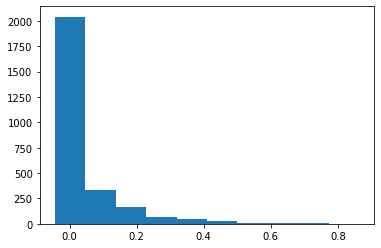

In [ ]:
import matplotlib.pyplot as plt
plt.hist(kl)

In [ ]:
np.shape(gmy)

(2708,)

In [ ]:
gmX[0].means_[0][0]

0.03499064062322888

In [ ]:
ks_scores_statistic = [i for i,j in [kstest(HH[a],YY[a]) for a in range(2708)]]

In [ ]:

def compute_fast_KL( m1, s1, p1, m2, s2, p2):
    '''Compute the KLDivergence between two gaussians, KL(P|Q) scaled between 0 and 1'''
    #note: precision = p = inv(s)
    d = len(m1)
    #print(d)
    kl = 0.5*( np.log2( np.linalg.det(s2)/np.linalg.det(s1) ) - d + np.trace(np.matmul(p2, s1)) + ((m2-m1).T)@(p2)@(m2-m1) )
    scaled_kl = 1 - np.exp(-kl)

    return scaled_kl

In [ ]:
gmXin = GaussianMixture(n_components=1, random_state=0).fit(HH.detach().to('cpu').numpy())
gmY = GaussianMixture(n_components=1, random_state=0).fit(YY.detach().to('cpu').numpy())
scaled_KL = compute_fast_KL(m1=gmXin.means_[0], s1=gmXin.covariances_[0], p1 = gmXin.precisions_[0],
            m2=gmY.means_[0], s2 = gmY.covariances_[0], p2 = gmY.precisions_[0])

7


In [ ]:
gmXin.means_[0]

array([ 0.14681828,  0.105377  , -0.13598958,  0.0999996 ,  0.14964377,
       -0.13393594, -0.01462713])

In [ ]:
scaled_KL

0.9738049663821569

In [ ]:

sscore = 10
bscore = 10
def proximal_L21(x: Tensor, lambda_):
    print(x.size())
    row_norm = torch.norm(x, p=2, dim=1)
    #print(row_norm)
    print(f"row norm size = {row_norm.size()}")
    global bscore
    score = torch.clamp(row_norm - lambda_, min=0)
    bscore = score
    print(f"score size = {score.size()}")

    index = torch.where(row_norm > 0)             #  Deal with the case when the row_norm is 0
    print(f"row index size = {index[0].size()}")
    #print
    score[index] = score[index] / row_norm[index] # score is the adaptive score in Equation (14)
    global sscore
    sscore = score
    print(f" size = {row_norm.size()}")
    print(score.unsqueeze(1).size())
    return score.unsqueeze(1) * x

In [ ]:

gamma = 1 / (2 * (1 - args.lambda_amp))

In [ ]:
p = proximal_L21(x = YY-HH,lambda_ = gamma*args.lambda_amp)
x = HH + proximal_L21(x=YY - HH, lambda_=gamma * args.lambda_amp) # Equation (11) and (12)


torch.Size([2708, 7])
row norm size = torch.Size([2708])
score size = torch.Size([2708])
row index size = torch.Size([2708])
 size = torch.Size([2708])
torch.Size([2708, 1])
torch.Size([2708, 7])
row norm size = torch.Size([2708])
score size = torch.Size([2708])
row index size = torch.Size([2708])
 size = torch.Size([2708])
torch.Size([2708, 1])


In [ ]:
p.size()

In [ ]:
np.unique(bscore,return_counts = True)

# Proximal using KS Test statistic
* Compute ks test for each row of of yy with each row of hh to get score and then multiply score with x 

In [ ]:
from scipy.stats import kstest
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
np.shape(HH[2])

In [ ]:
YY[2].size()

In [ ]:
kstest(YY[1000].detach().numpy().flatten(),YY[5].detach().numpy().flatten())

In [ ]:
YY[2707]

In [ ]:
YY[55]

In [ ]:
np.unique(ks_scores,return_counts = True)

In [ ]:
np.unique(ks_scores_statistic,return_counts = True)

In [ ]:
ks_scores = [j for i,j in [kstest(HH[a],YY[a]) for a in range(2708)]]

In [ ]:
ks_scores_statistic = [i for i,j in [kstest(HH[a],YY[a]) for a in range(2708)]]

In [ ]:
ind = np.where()

In [ ]:
yd = YY[1000].detach().numpy().flatten()

In [ ]:
plt.plot(np.sort(yd),1.*np.arange(7)/6)

In [ ]:
plt.plot(np.sort(yd),1.*np.arange(7)/6)

In [ ]:
np.unique(ks_scores,return_counts= 1)

In [ ]:
np.unique(sscore,return_counts = 1)

In [ ]:
gamma

In [ ]:
x.size()

In [ ]:
sscore.size()

In [ ]:
x[1]

In [ ]:
XX

In [ ]:
sscore

In [ ]:
sscore.unsqueeze(1).size()